# Strojno učenje - PMF

Akademska godina 2017./2018.
[https://web.math.pmf.unizg.hr/nastava/su/](https://web.math.pmf.unizg.hr/nastava/su/)

Matija Piškorec

kernel: Python 3.6

# 5. Učenje bez nadzora

Nenadzirano učenje (engl. unsupervised learning) podrazumijeva učenje bez ciljne značajke. Za više informacija pogledajte stranicu [Clustering](http://scikit-learn.org/stable/modules/clustering.html) iz službene scikit-learn korisničke dokumentacije.

Preduvjeti
--------------

U ovoj vježbi koristit ćemo i [`20newsgroups`](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html#newsgroups) dataset koji se sastoji od 18000 tekstova podjeljenih u 20 kategorija, a koji je zbog veličine dostupan i lokalno u repozitoriju ovih vježbi.

Za ostale datasetove dostupne unutar scikit-learna pogledajte službenu dokumentaciju na [`sklearn.datasets`](http://scikit-learn.org/dev/modules/classes.html#module-sklearn.datasets).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

5.1. Grupiranje s algoritmom k-srednjih vrijednosti
-----------------------------------------

U sljedećem primjeru koristit ćemo algoritam k-srednjih vrijednosti (engl. k-means clustering) za grupiranje. Ovaj primjer je preuzet iz [Demonstration of k-means assumptions](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py) iz scikit-learn korisničke dokumentacije. Algoritam k-srednjih vrijednosti pokušava naći centroide grupa $\mu_i$ i potom dodjeliti svaki uzorak $x_j$ jednoj od grupa tako da je suma kvadratnih udaljenost uzoraka od centra pripadajućih grupa minimalna:

$$
\sum_{i=0}^{n}\min_{\mu_j \in C}(\|x_j - \mu_i\|^2)
$$

Za evaluaciju ćemo koristiti normaliziranu uzajamnu informaciju (engl. normalized mutual information, NMI) implementiranu u funkciji [`sklearn.metrics.normalized_mutual_info_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html#sklearn.metrics.normalized_mutual_info_score). Ova mjera je normalizirana od 0 do 1 pri čemu vrijednost 0 označava u potpunosti nezavisno grupiranje dok 1 označava savršeno grupiranje s obzirom na neke unaprijed poznate labele (ovo nije slučaj s nenormaliziranom mjerom [`sklearn.metrics.mutual_info_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mutual_info_score.html#sklearn.metrics.mutual_info_score)).

In [ ]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import normalized_mutual_info_score

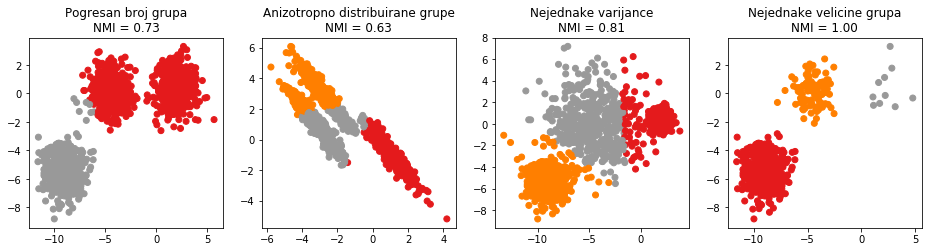

In [2]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3.5))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Pogresan broj grupa
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)
score = normalized_mutual_info_score(y,y_pred)

ax[0].scatter(X[:, 0], X[:, 1], c=y_pred, cmap=plt.cm.Set1)
ax[0].set(title="Pogresan broj grupa\nNMI = " + '{0:.2f}'.format(score))

# Anizotropno distribuirane grupe
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)
score = normalized_mutual_info_score(y,y_pred)

ax[1].scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred, cmap=plt.cm.Set1)
ax[1].set(title="Anizotropno distribuirane grupe\nNMI = " + '{0:.2f}'.format(score))

# Nejednake varijance
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)
score = normalized_mutual_info_score(y_varied,y_pred)

ax[2].scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred, cmap=plt.cm.Set1)
ax[2].set(title="Nejednake varijance\nNMI = " + '{0:.2f}'.format(score))

# Nejednake velicine grupa
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_filtered = np.hstack((y[y == 0][:500], y[y == 1][:100], y[y == 2][:10]))
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_filtered)
score = normalized_mutual_info_score(y_filtered,y_pred)

ax[3].scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred, cmap=plt.cm.Set1)
ax[3].set(title="Nejednake velicine grupa\nNMI = " + '{0:.2f}'.format(score))

plt.show()

**Vježba 5.1.** Iskoristite neku drugu metodu grupranja u sciki-learnu i usporedite rezultate s onima dobivenima algoritmom k-srednjih vrijednosti. Primjerice, probajte [`sklearn.cluster.SpectralClustering`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering), [`sklearn.cluster.AffinityPropagation`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation) ili [`sklearn.cluster.DBSCAN`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN).

5.2. Modeliranje tema s NMF-om
-----------------------------------------

U sljedećem primjeru koristit ćemo ne-negativnu matričnu faktorizaciju (eng. non-negative matrix factorization, NMF) za modeliranje tema u tekstualnim dokumentima. NMF pretpostavlja da su podaci ne-negativni i daje additivne komponente koje se lako interpretiraju, pogotovo u domenama kao što su slike i tekst. U modeliranju tema, gdje je svaki dokument raprezentiran s bag-of-words reprezentacijom, komponente koje daje NMF se interpretiraju kao teme koje dokument pokriva, od kojih svaka daje određenu vjerojatnost za pojavljivanje određenih riječi. Za više detalja pogledajte službenu dokumentaciju ["2.5.6. Non-negative matrix factorization (NMF or NNMF)"](http://scikit-learn.org/stable/modules/decomposition.html#nmf). 

Koristit ćemo [`sklearn.datasets.fetch_20newsgroups`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups) dataset koji se sastoji od tekstova koji pripadaju jednoj od nekoliko različitih tema. Za sličan primjer pogledajte ["Topics extraction with NMF"](http://scikit-learn.org/0.16/auto_examples/applications/topics_extraction_with_nmf.html) u službenoj scikit-learn dokumentaciji.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.datasets import fetch_20newsgroups

In [5]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'),
                             data_home='../assets/datasets/zip/',
                             download_if_missing=False) # dataset je dostupan lokalno

print('Ucitano ' + str(len(dataset.data)) + ' dokumenata.')

Ucitano 11314 dokumenata.


Kako izgleda prvih nekoliko tekstova, zajedno s temama.

In [6]:
[t.upper()+' => '+s[:300]+'[...]' for s,t in zip(dataset.data[:5],np.take(dataset.target_names,dataset.target[:5]))]

["TALK.POLITICS.MIDEAST => Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one desc[...]",
 "ALT.ATHEISM => \n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap of faith, Jimmy.  Your logic runs out\nof steam!\n\n\n\n\n\n\n\nJim,\n\nSorry I can't pity you, Jim.  And I'm sorry that you have these feelings of\ndenial about the faith you need to get by.  O[...]",
 'TALK.POLITICS.MIDEAST => Although I realize that principle is not one of your strongest\npoints, I would still like to know why do do not ask any question\nof this sort about the Arab countries.\n\n   If you want to continue this think tank charade of yours, your\nfixation on Israel must stop.  You might have to 

I sve moguće teme su:

In [7]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Prilikom učitavanja dataseta već smo uklonili zaglavlja i ostatak suvišnog teksta. Iskoristit ćemo [`sklearn.feature_extraction.text.TfidfVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) za stvaranje TF-IDF (term frequency - inverse document frequency) vektora za svaki dokument. U njemu svaki atribut odgovara jednom terminu kojeg pratimo u dokumentima, pri čemu je njegova vrijednost proporcionalna učestalosti termina u danom dokumentu a obrnuto proporcionalna učestalosti termina u svim dokumentima. Tako će termini koji su relativno rijetki nositi veću težinu jer je vjerojatnije da su važni za temu dokumenta. Također ćemo ukloniti riječi koje se pojavljuju samo u jednom dokumentu (`min_df=2`) ili u više od 95% svih dokumenata (`max_df=0.95`), kao i stop riječi koje ne nose puno semantičkog značenja (`stop_words='english'`). Dodatno, odabrat ćemo najučestalijih 1000 termina koji zadovoljavaju ove kriterije (`max_featuers=1000`).

In [8]:
n_samples = 2000
n_features = 1000
n_topics = 10
n_top_words = 15

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
tfidf = vectorizer.fit_transform(dataset.data[:n_samples])
tfidf

<2000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 51752 stored elements in Compressed Sparse Row format>

Naš dataset je sad u formu rijetke matrice gdje atributi (stupci) odgovaraju naših 1000 odabranih atributa a primjeri (retci) su pojedinačni dokumenti. Konačno, idemo primjeniti NMF na danoj TF-IDF reprezentaciji koristeći [`sklearn.decomposition.NMF`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF).

In [9]:
print('NMF model s ' + str(n_samples) + ' primjera i ' + str(n_features) + ' znacajki.')
nmf = NMF(n_components=n_topics, random_state=1).fit(tfidf)

feature_names = vectorizer.get_feature_names()

for topic_idx, topic in enumerate(nmf.components_):
    print("Tema #%d:" % topic_idx + ' ' + " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]))

NMF model s 2000 primjera i 1000 atributa.
Tema #0: just people don think like know say did make really time way ve right sure
Tema #1: windows use using window dos program application os drivers software help screen running ms code
Tema #2: god jesus bible faith does christian christians christ believe life heaven sin lord church religion
Tema #3: thanks know does mail advance hi info interested anybody email like looking help appreciated card
Tema #4: car new 00 bike 10 price space cars power sale good year engine years used
Tema #5: edu soon com send university internet ftp mail mit information article cc pub address hope
Tema #6: file problem files format ftp win space sound read pub available program site help version
Tema #7: game team year games win play season players nhl runs toronto ll flyers division goal
Tema #8: drive drives hard disk card software floppy mac pc apple power computer scsi controller memory
Tema #9: key chip government clipper encryption keys use public law 

**Vježba 5.2.** Iskoristite neku drugu tehniku za redukciju dimenzionalnosti za modeliranje tema na danom datasetu, primjerice dekompoziciju singularnih vrijednosti (SVD) implementiranu u [`sklearn.decomposition.TruncatedSVD`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html), što je poznato kao latentna semantička analiza (engl. latent semantic analysis, LDA), ili PCA implementiranu u [`sklearn.decomposition.PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA), ili bilo koju drugu dekompozicijsku metodu u [`sklearn.decomposition`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition). Usporedite rezultate s NMF-om. Jesu li teme smislene? Napomena: Neke metode, kao što je PCA, rade samo na gustim (engl. dense) matricama, pa ćete prije korištenja morati pretvoriti rijetke matrice u guste s `tfidf.todense()`. TFIDF vektorske reprezentacije koje daje [`sklearn.feature_extraction.text.TfidfVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) su rijetke.

In [10]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

In [11]:
print('Ucenje SVD modela s ' + str(n_samples) + ' uzoraka i ' + str(n_features) + ' znacajki.')
nmf = TruncatedSVD(n_components=n_topics).fit(tfidf)

feature_names = vectorizer.get_feature_names()

for topic_idx, topic in enumerate(nmf.components_):
    print("Tema #%d:" % topic_idx + ' ' + " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

Ucenje SVD modela s 2000 uzoraka i 1000 znacajki.
Tema #0: just like don know people think does good use time new god way ve want
Tema #1: god people think just jesus don bible say law government did life believe christian faith
Tema #2: god does thanks jesus know bible windows faith christian file mail christians edu advance hi
Tema #3: edu thanks know game mail interested like bike car advance email games team list don
Tema #4: key government know edu chip people encryption clipper thanks don law public keys does right
Tema #5: edu god 00 com key new soon power chip sale 10 university government car send
Tema #6: edu file think windows program soon game win files com ftp team window pub play
Tema #7: game team key does games year chip clipper play thanks win encryption players keys season
Tema #8: drive think drives hard disk don chip going mac floppy card software thanks edu team
Tema #9: key god use chip edu good clipper just think keys ll like car don game


In [12]:
print('Ucenje PCA modela s ' + str(n_samples) + ' uzoraka i ' + str(n_features) + ' znacajki.')
nmf = PCA(n_components=n_topics).fit(tfidf.todense()) # PCA radi samo na punim matricama!

feature_names = vectorizer.get_feature_names()

for topic_idx, topic in enumerate(nmf.components_):
    print("Tema #%d:" % topic_idx + ' ' + " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

Ucenje PCA modela s 2000 uzoraka i 1000 znacajki.
Tema #0: people god think just don say government law like did jesus bible make way believe
Tema #1: god does jesus bible edu thanks faith christian christians christ mail heaven true lord church
Tema #2: know windows does thanks like don use file help people need problem using just program
Tema #3: know thanks edu mail don like game does interested just advance bike info email car
Tema #4: edu key government chip clipper encryption keys people public com law information enforcement phone rights
Tema #5: file edu think windows game win files program team ftp just window soon play don
Tema #6: edu drive soon think car just god problem good need power mac don com 00
Tema #7: drive think people drives hard card disk software don thanks floppy game mac apple computer
Tema #8: game key god chip edu team clipper ll keys year games encryption card good season
Tema #9: just use chip key does drive thought sure think got good clipper doesn speed

**Vježba 5.3.** Iskoristite NMF kao metodu za smanjivanje dimenzionalnosti i evaluirajte prediktivnu moć na nekom od klasifikatora koji smo koristili ranije, te usporedite rezultate dobivene bez primjene NMF-a. Napomena: Pošto je [`20newsgroups`](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html#newsgroups) dataset s više od dvije klase, razmislite o korištenju klasifikatora koji podržava više klasa. Srećom, većina klasifikatora koje smo koristili rade na višeklasnim problemima. Za više detalja pogledajte službenu dokumentaciju ["1.12. Multiclass and multilabel algorithms"](http://scikit-learn.org/stable/modules/multiclass.html).